# Distribution Analysis of Data and Segment Analysis
## Author: Nivethan Iyer 1171632


This Notebook is for generating visualizations across different features of our datasets. We analyse the distributions of each features and assess which features have concerning outliers or concerning distributions that require changes. We also look at the distributions of each segment which will aid our analysis of which industries have higher quality merchants.

In [6]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [7]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()

+------------+--------------------+-------------+---------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+-----------------+------------------+------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|average_monthly_diff_consumers|consumer_d

First we generate the distribution of each feature to analyse the nature of the distribution (Gaussian, Poisson, Exponential) and identify if there are any forms of noise or strong outliers which could distort our analysis.

Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



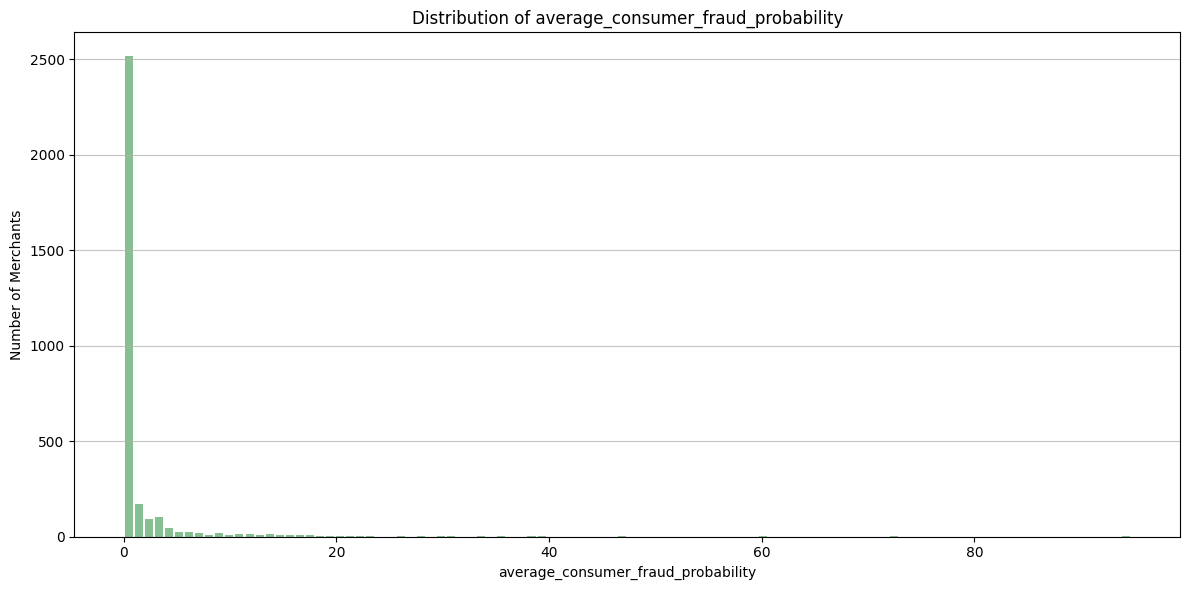

Summary Statistics for avg_median_age:

count    4026.000000
mean       43.112349
std         0.991092
min        26.000000
25%        42.913605
50%        43.107035
75%        43.300379
max        55.000000
Name: avg_median_age, dtype: float64

--------------------------------------------------



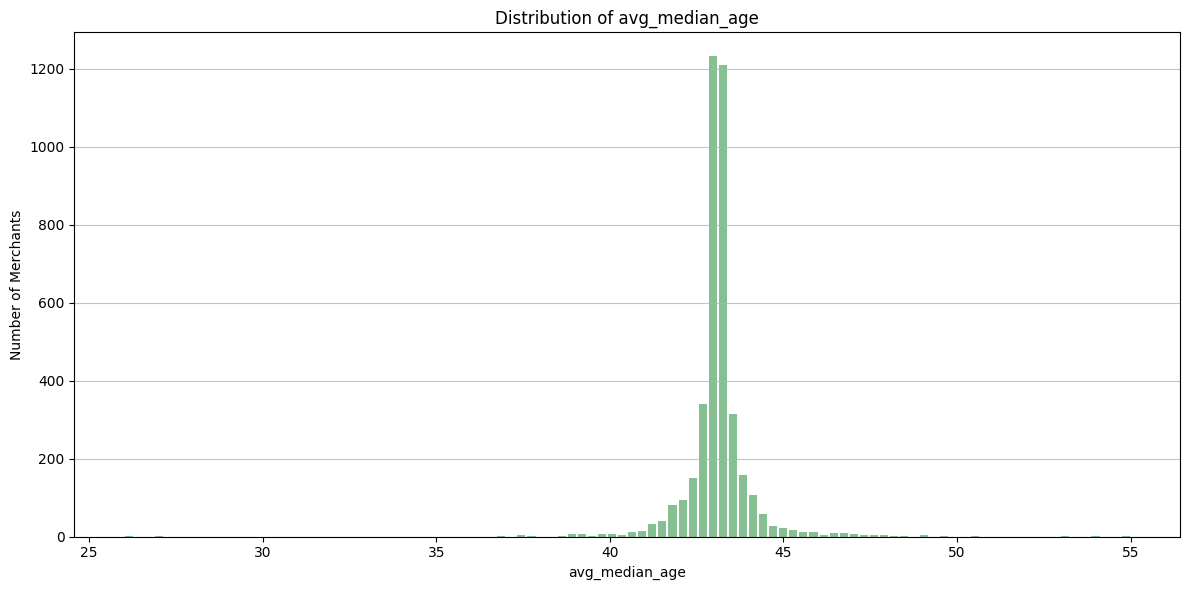

Summary Statistics for avg_total_weekly_personal_income:

count    4026.000000
mean      789.579167
std        30.273343
min       471.000000
25%       782.828468
50%       790.159310
75%       796.630394
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



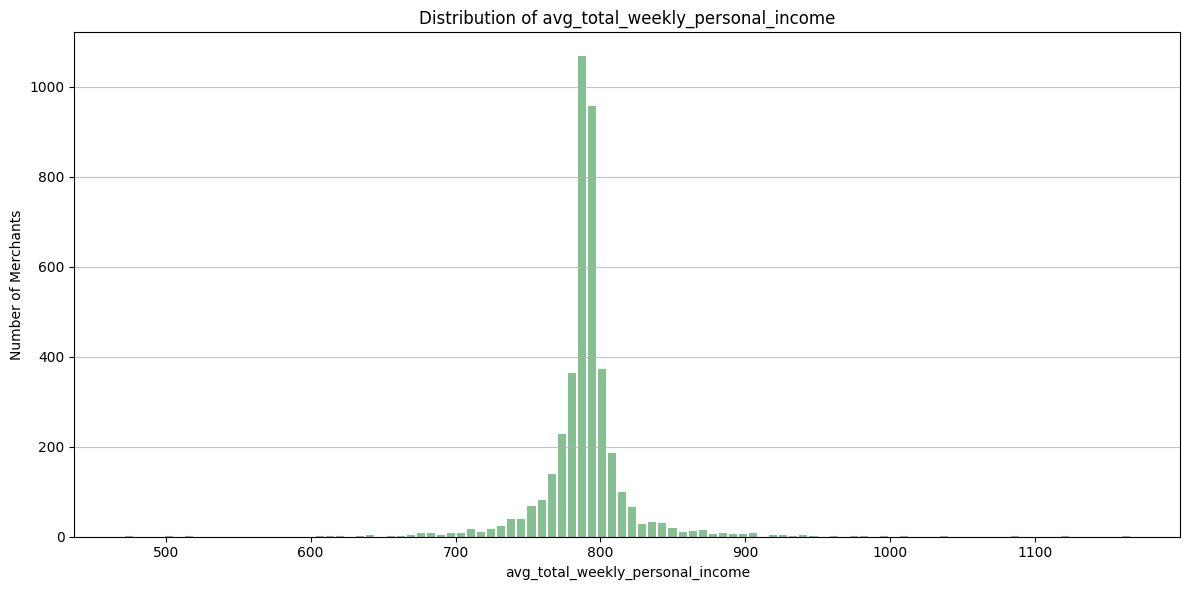

Summary Statistics for take_rate:

count    4026.000000
mean        4.397575
std         1.782595
min         0.100000
25%         2.970000
50%         4.500000
75%         6.030000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



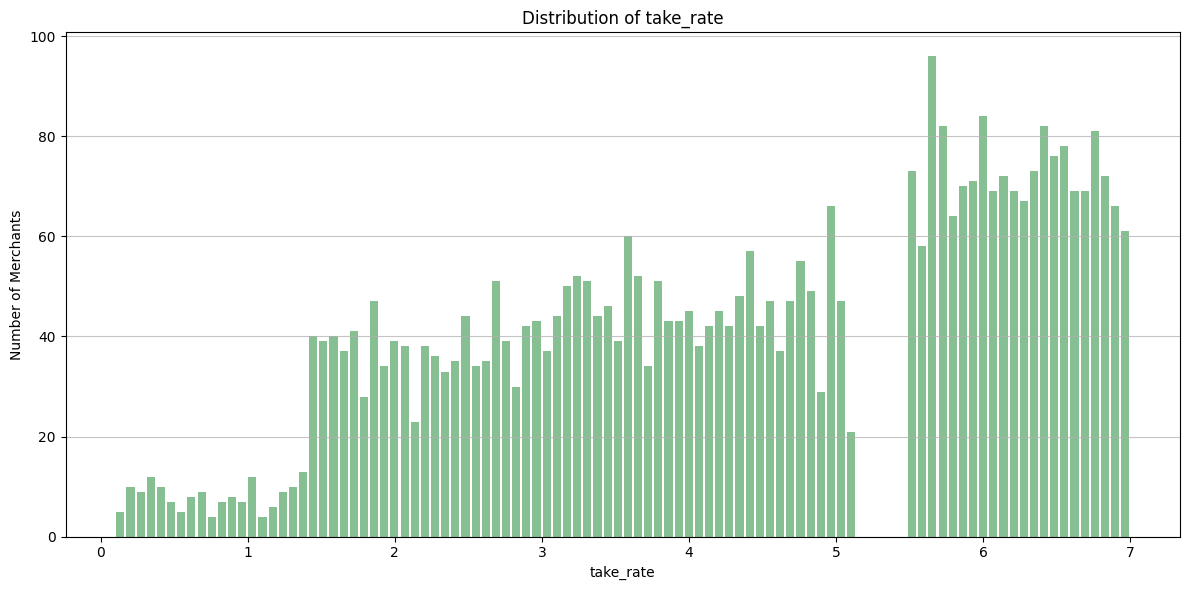

Summary Statistics for average_cost_of_order:

count     4026.000000
mean      1162.394858
std       2972.212606
min          7.579026
25%        118.295487
50%        317.551494
75%        841.489967
max      51876.640000
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



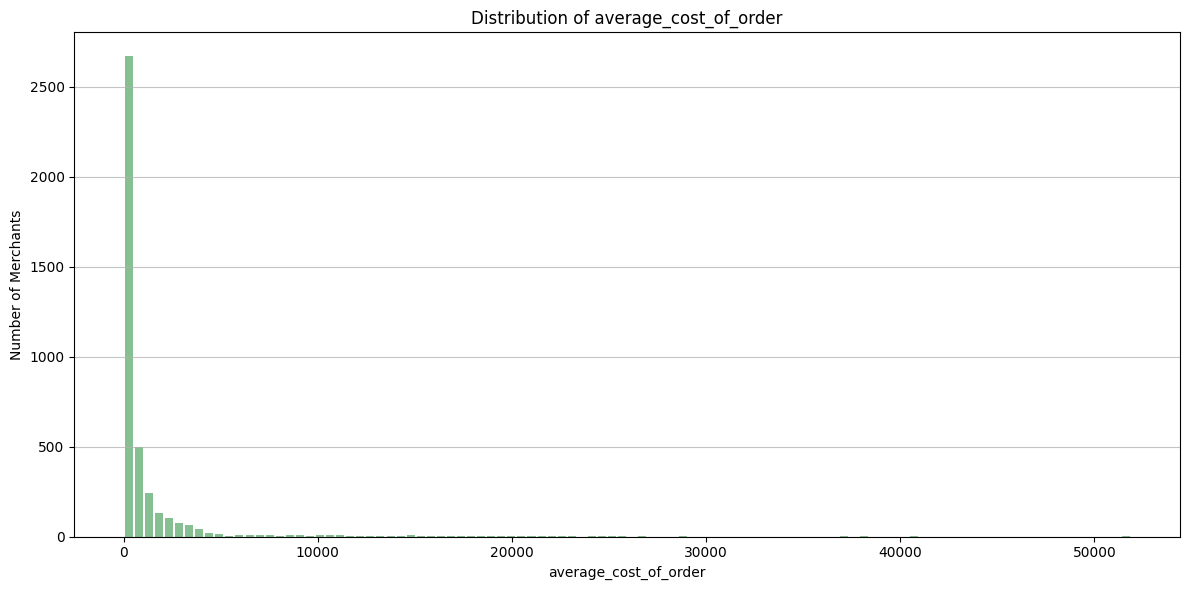

Summary Statistics for number_of_orders:

count      4026.000000
mean       2824.824888
std       11816.655769
min           1.000000
25%          78.250000
50%         352.000000
75%        1718.500000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



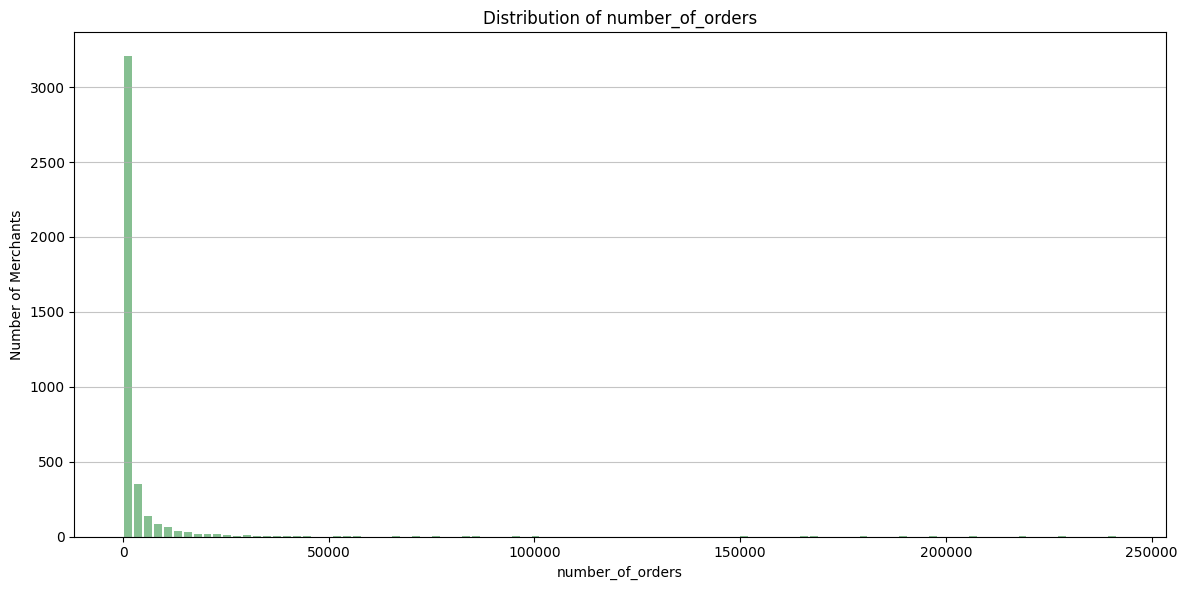

Summary Statistics for number_of_unique_consumers:

count     4026.000000
mean      1691.663189
std       3236.959538
min          1.000000
25%         78.250000
50%        349.000000
75%       1643.500000
max      20115.000000
Name: number_of_unique_consumers, dtype: float64

--------------------------------------------------



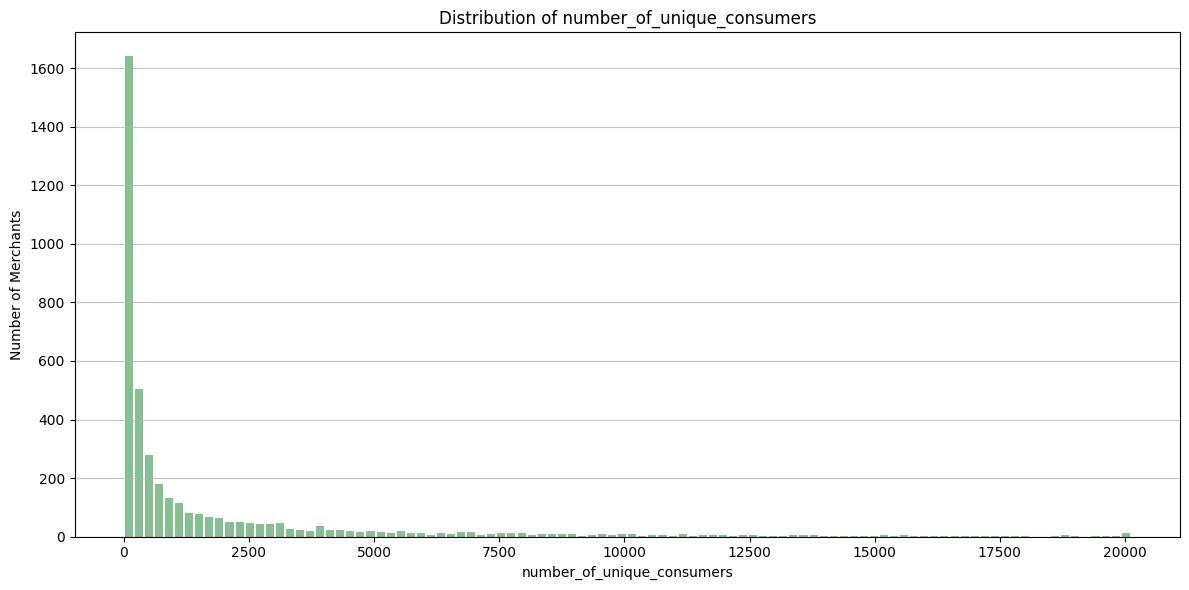

Summary Statistics for average_merchant_fraud_probability:

count    47.000000
mean      1.313311
std       2.898382
min       0.125353
25%       0.259682
50%       0.724312
75%       1.153219
max      18.210900
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



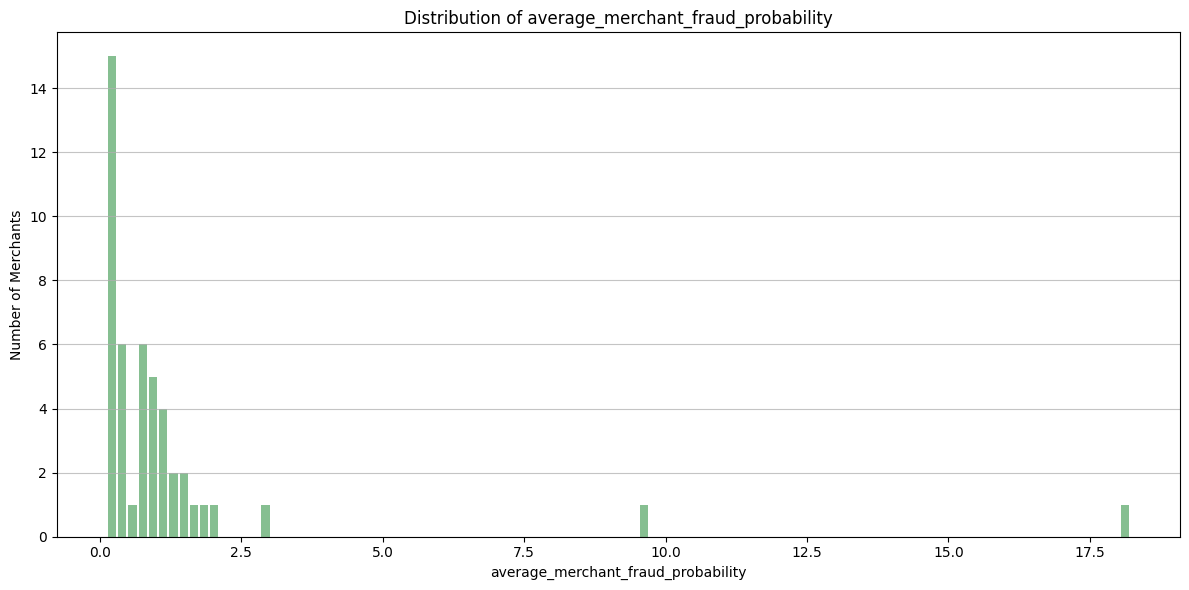

Summary Statistics for average_consumer_fraud_probability:

count    3135.000000
mean        1.314906
std         4.332110
min         0.004561
25%         0.045017
50%         0.075769
75%         0.493818
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



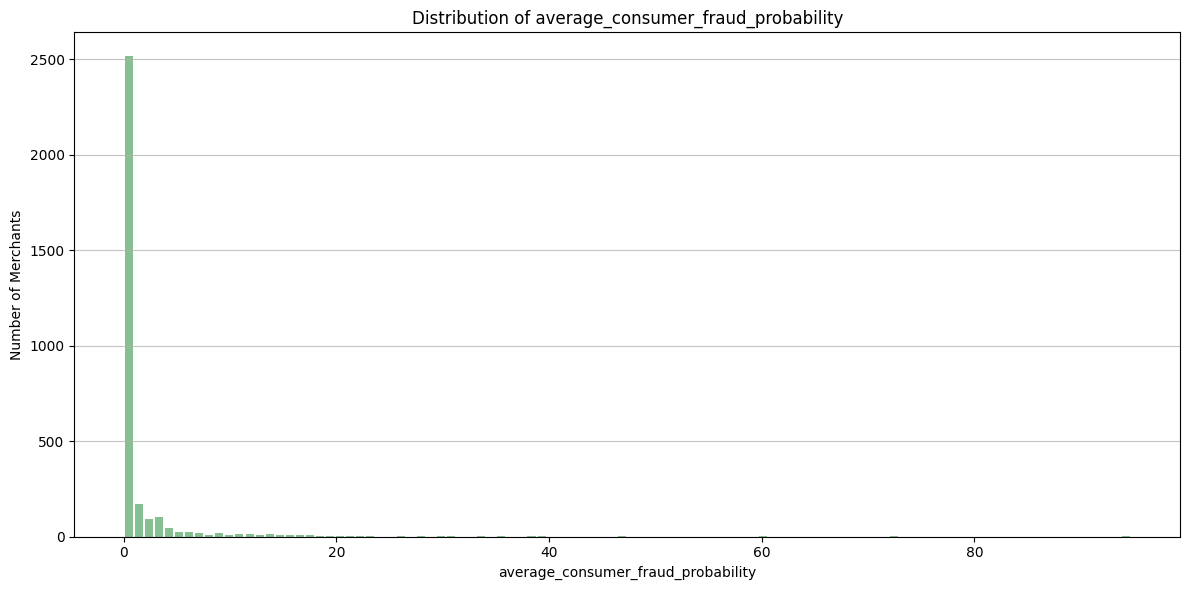

In [10]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_unique_consumers",
    "average_merchant_fraud_probability",
    "average_consumer_fraud_probability", 
]

df_pandas = df.toPandas()
for column in columns_to_analyze:
    filtered_df = df.filter(
    (F.col(column) > 0) 
)   
    df_pandas = filtered_df.toPandas()
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


Looking at the summary statistics for consumer fraud  and number of unique consumers we can see certain merchants that are outliers so we will consider removing these in our outlier analysis. The distributions for other features seem to have reasonable distributions.

We will now move on to looking at performing some segment analysis. First we make a bar chart for each of the different segments analysingt the consumer fraud and number of orders

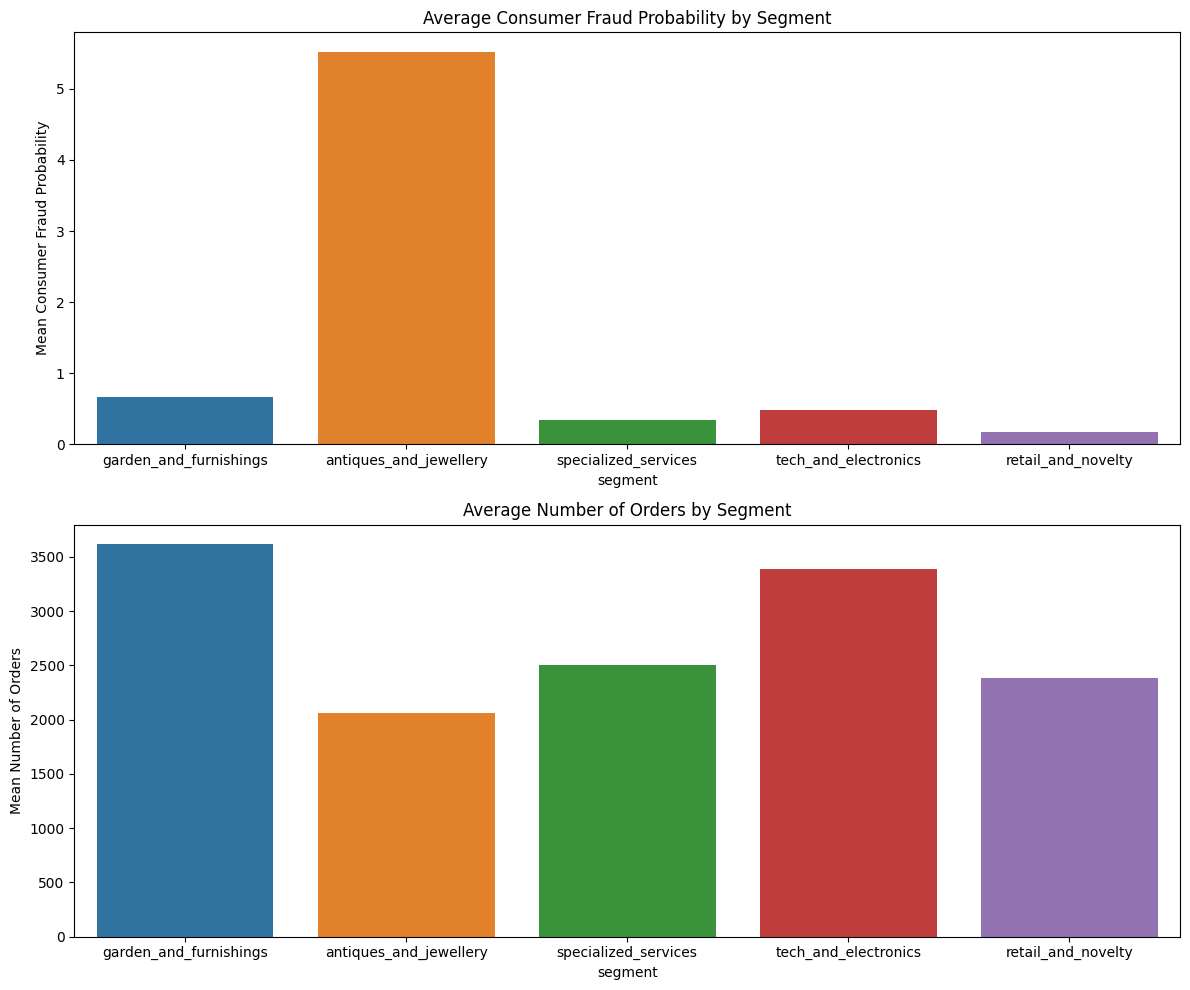

In [11]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Group by segment and aggregate the mean and standard deviation
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()


We also create pie chart to assess which segments have the highest percentages of revenue. We can also compare this in the future with our ranking system to see the distribution of industries for the top 100 merchants.

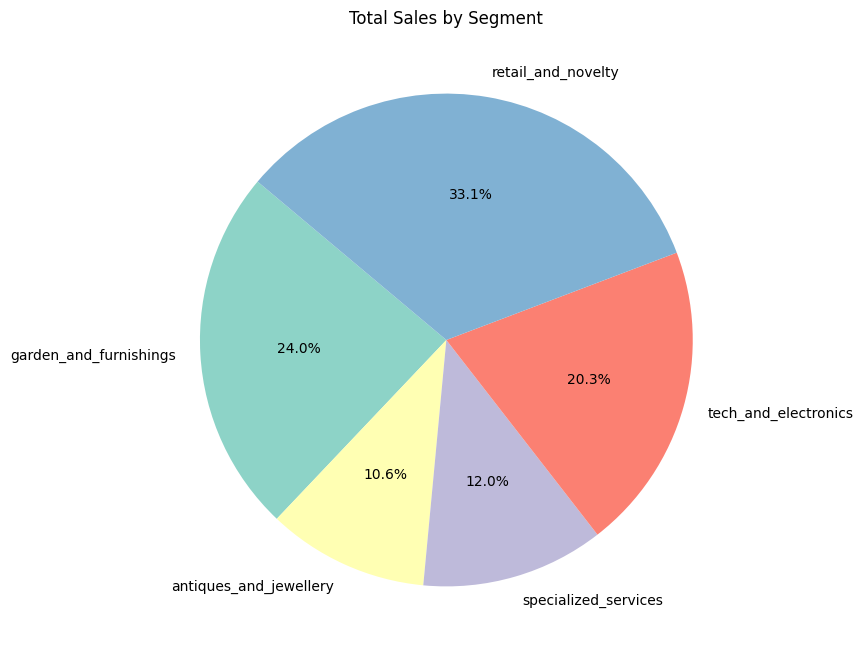

In [12]:
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

sales_pandas = agg_sales.toPandas()

plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()


## Summary

We analysed different visualizations and distributions and noticed some outlier insights which we will remove in the outlier analysis notebook. We also visualized the distributions of features across each segment to notice any distinguishing insights or trends and found the antiques and jewellery to have a relatively higher consumer fraud.